### Imputación de datos faltantes

Imputa las temperaturas faltantes por diferentes métodos:
- simple (lineal)
- por tiempo
- polinómica de grado 2
- BiLSTM


In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [31]:
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) 

In [65]:
from pykalman import KalmanFilter

def kalman_simple(y, q=0.01, r=1.0):
    """
    Kalman simple con un solo estado.
    q = varianza del estado (cuánto puede cambiar el verdadero valor)
    r = varianza del ruido de observación (cuánto ruido tiene la medición)

    """
    y = pd.Series(y)
    arr = y.to_numpy()

    # Modelo mínimo: x_t = x_{t-1} + w  ;   y_t = x_t + v
    kf = KalmanFilter(
        transition_matrices=np.array([[1]]),
        observation_matrices=np.array([[1]]),
        transition_covariance=np.array([[q]]),
        observation_covariance=np.array([[r]]),
    )

    smoothed, _ = kf.smooth(arr)
    return pd.Series(smoothed[:,0], index=y.index)


In [32]:
# después de imputar, completo las otras columnas, que dependen de las primeras.
# clip de outliers (opcional)
def set_mes_delta(df, clip=True):

    df['mes'] = df['fecha'].dt.month
    df['delta'] = df['estepa']- df['pino']

    if clip:
        q1 = df['delta'].quantile(.25)
        q3 = df['delta'].quantile(.75)
        pmin_delta = q1 - (q3-q1)*1.5
        pmax_delta = q3 + (q3-q1)*1.5
        df['delta'] = df['delta'].clip(lower=pmin_delta, upper=pmax_delta)


In [33]:
# plot de delta con línea de valores extremos
def plot_delta(df, titulo=''):
    fig, axs = plt.subplots(1, 1, figsize=(14, 4))

    q1 = df['delta'].quantile(.25)
    q3 = df['delta'].quantile(.75)
    pmin_delta = q1 - (q3-q1)*1.5
    pmax_delta = q3 + (q3-q1)*1.5
            
    plt.bar(df['fecha'], df['delta'])
    # Línea horizontal en los percentiles extremos
    plt.axhline(y=pmin_delta, linestyle='--', linewidth=1, color='blue', label=f'{pmin_delta:.2f}')
    plt.axhline(y=pmax_delta, linestyle='--', linewidth=1, color='red', label=f'{pmax_delta:.2f}')
    plt.title(titulo)
    plt.grid(axis='y')
    plt.legend()
    plt.show()  


#### Lee las temperaturas diurnas x día

In [34]:
# Temperaturas diurnas (diarias)
df_dia = pd.read_csv("csv/ts_d_diario.csv", parse_dates=["fecha"],
    dtype={"pino": "float64",
           "estepa": "float64",
           "mes": "int64",
           "delta": "float64"
          })
df_dia.head(10)

,fecha,estepa,pino,mes,delta
0,2020-01-01,35.433453,33.666374,1,1.767079
1,2020-01-02,36.195872,31.342840,1,4.853032
2,2020-01-03,35.245773,31.284172,1,3.961601
3,2020-01-04,38.821326,31.450303,1,7.371023
4,2020-01-05,NaN,17.944593,1,NaN
5,2020-01-06,NaN,NaN,1,NaN
6,2020-01-07,25.590980,19.523039,1,6.067942
7,2020-01-08,NaN,NaN,1,NaN
8,2020-01-09,NaN,NaN,1,NaN
9,2020-01-10,27.450967,22.472114,1,4.978853


In [35]:
# Estadísticas
df_dia[['estepa', 'pino', 'delta']].describe()

,estepa,pino,delta
count,1550.000000,1537.000000,1517.000000
mean,20.308426,17.074604,3.345054
std,13.046044,11.390663,2.356220
min,-13.921825,-10.614593,-8.212904
25%,8.566924,6.769585,1.609815
50%,21.533744,17.630912,3.358275
75%,31.620656,26.673017,4.998284
max,47.598174,42.566516,10.811992


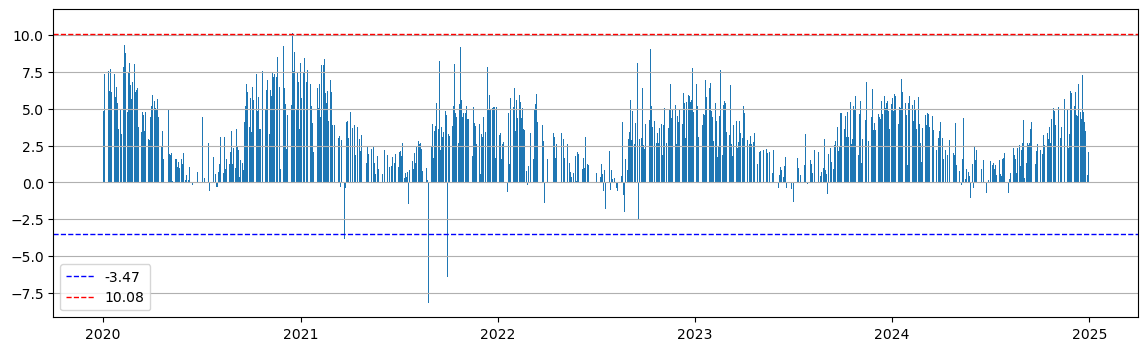

In [36]:
plot_delta(df_dia)

## Imputación simple

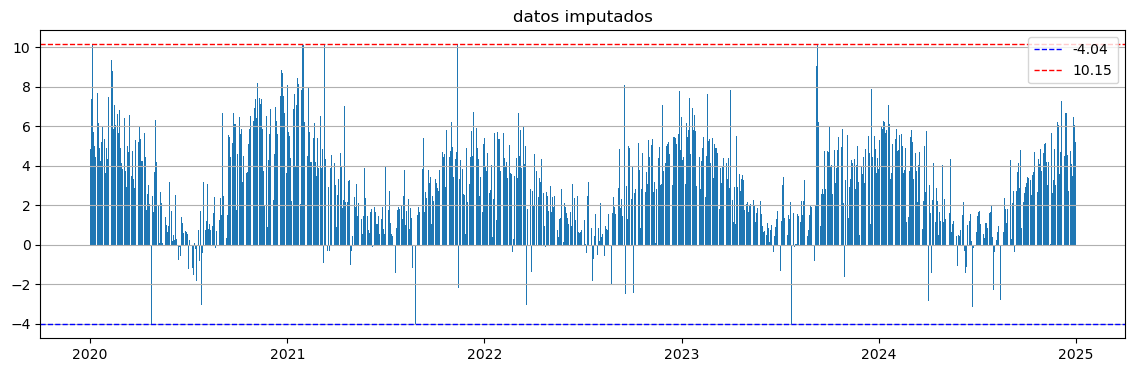

,fecha,estepa,pino,mes,delta
0,2020-01-01,35.433453,33.666374,1,1.767079
1,2020-01-02,36.195872,31.342840,1,4.853032
2,2020-01-03,35.245773,31.284172,1,3.961601
3,2020-01-04,38.821326,31.450303,1,7.371023
4,2020-01-05,34.411211,17.944593,1,10.151255
5,2020-01-06,30.001096,18.733816,1,10.151255
6,2020-01-07,25.590980,19.523039,1,6.067942
7,2020-01-08,26.210976,20.506064,1,5.704912
8,2020-01-09,26.830971,21.489089,1,5.341882
9,2020-01-10,27.450967,22.472114,1,4.978853


In [37]:
df_imputed = df_dia.copy()

df_imputed= df_imputed.set_index('fecha')
df_imputed['estepa'] = df_imputed['estepa'].interpolate(method='linear')
df_imputed['pino']   = df_imputed['pino'].interpolate(method='linear')
df_imputed = df_imputed.reset_index()

set_mes_delta(df_imputed, clip=True)

plot_delta(df_imputed, 'datos imputados')

df_imputed.head(15)

In [38]:
# Exporta el resultado
salida = 'csv/ts_imputado_simple.csv'
df_imputed[['fecha','estepa','pino','mes','delta']].to_csv(salida, index=False)

## Imputación por interpolación. Método 'time'

In [39]:
df_imputed = df_dia.copy()

df_imputed= df_imputed.set_index('fecha')
df_imputed['estepa'] = df_imputed['estepa'].interpolate(method='time')
df_imputed['pino']   = df_imputed['pino'].interpolate(method='time')
df_imputed = df_imputed.reset_index()

set_mes_delta(df_imputed)
df_imputed.head(20)

,fecha,estepa,pino,mes,delta
0,2020-01-01,35.433453,33.666374,1,1.767079
1,2020-01-02,36.195872,31.342840,1,4.853032
2,2020-01-03,35.245773,31.284172,1,3.961601
3,2020-01-04,38.821326,31.450303,1,7.371023
4,2020-01-05,34.411211,17.944593,1,10.151255
5,2020-01-06,30.001096,18.733816,1,10.151255
6,2020-01-07,25.590980,19.523039,1,6.067942
7,2020-01-08,26.210976,20.506064,1,5.704912
8,2020-01-09,26.830971,21.489089,1,5.341882
9,2020-01-10,27.450967,22.472114,1,4.978853


In [40]:
# Exporta el resultado
salida = 'csv/ts_imputado_time.csv'
df_imputed[['fecha','estepa','pino','mes','delta']].to_csv(salida, index=False)

## Imputación por interpolación. Método polinómico

In [41]:
df_imputed = df_dia.copy()

df_imputed= df_imputed.set_index('fecha')
df_imputed['estepa'] = df_imputed['estepa'].interpolate(method='polynomial', order=2)
df_imputed['pino']   = df_imputed['pino'].interpolate(method='polynomial', order=2)
df_imputed = df_imputed.reset_index()

set_mes_delta(df_imputed)
df_imputed.head(15)

,fecha,estepa,pino,mes,delta
0,2020-01-01,35.433453,33.666374,1,1.767079
1,2020-01-02,36.195872,31.342840,1,4.853032
2,2020-01-03,35.245773,31.284172,1,3.961601
3,2020-01-04,38.821326,31.450303,1,7.371023
4,2020-01-05,37.634369,17.944593,1,10.157978
5,2020-01-06,31.017693,15.534118,1,10.157978
6,2020-01-07,25.590980,19.523039,1,6.067942
7,2020-01-08,22.457512,20.567543,1,1.889969
8,2020-01-09,22.104028,19.628610,1,2.475419
9,2020-01-10,27.450967,22.472114,1,4.978853


In [42]:
# Exporta el resultado
salida = 'csv/ts_imputado_polinomio.csv'
df_imputed[['fecha','estepa','pino','mes','delta']].to_csv(salida, index=False)

## Imputación con BiLSTM

In [43]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Bidirectional, LSTM, Dropout, Dense, TimeDistributed
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [44]:
df = df_dia.copy()

In [45]:
cols_to_impute = ['estepa', 'pino']
data = df[cols_to_impute].copy()

data.head(10)

,estepa,pino
0,35.433453,33.666374
1,36.195872,31.342840
2,35.245773,31.284172
3,38.821326,31.450303
4,NaN,17.944593
5,NaN,NaN
6,25.590980,19.523039
7,NaN,NaN
8,NaN,NaN
9,27.450967,22.472114


In [46]:
# Parámetros
TEST_SIZE_FOR_MASK = 0.15        # 15 % de valores CONOCIDOS los borramos artificialmente para validar
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [47]:
# Máscara de valores REALMENTE faltantes + máscara de validación artificial

real_missing = data.isna().values                     # True donde faltan de verdad
known_values = ~real_missing                          # True donde SÍ tenemos valor real

# Borramos artificialmente un % de los valores que sí conocemos (para validar)
mask_val = np.random.random(data.shape) < TEST_SIZE_FOR_MASK
mask_val = mask_val & known_values                    # solo borramos donde había valor real

validation_missing = mask_val.copy()                  # estos los usamos para medir error realista
train_missing = real_missing | validation_missing     # valtantes verdaderos y artificiales

# Serie que el modelo verá (con todos los gaps: verdaderos y artificiales)
data_train = data.copy()
data_train.values[train_missing] = np.nan

In [48]:
# Relleno provisorio para poder entrenar (solo interpolación simple)
data_filled = data_train.interpolate(method='linear', limit_direction='both')
data_filled = data_filled.fillna(method='bfill').fillna(method='ffill')

In [49]:
# Normalización
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
data_scaled = pd.DataFrame(
    scaler.fit_transform(data_filled),
    index=data_filled.index,
    columns=data_filled.columns
)

In [50]:
# Preparamos tensores (una sola secuencia grande)
X_train = data_scaled.values.reshape(1, -1, 2)      # shape (1, n_timesteps, 2)
X_with_real_gaps = np.where(train_missing, 0, data_scaled.values)
X_with_real_gaps = X_with_real_gaps.reshape(1, -1, 2)
y_train = X_train[:, :, :2]    # dos variables: estepa y pino

In [51]:
# Modelo BiLSTM multivariado

model = Sequential([
    Input(shape=(None, 2)),
    Bidirectional(LSTM(128, activation='tanh', return_sequences=True, recurrent_dropout=0.2)),
    Bidirectional(LSTM(64, activation='tanh', return_sequences=True, recurrent_dropout=0.2)),
    Bidirectional(LSTM(32, activation='tanh', return_sequences=True, recurrent_dropout=0.1)),
    TimeDistributed(Dense(2))
])

# model.compile(optimizer=Adam(learning_rate=0.0005), loss='mse')

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_3 (Bidirectional) │ (None, None, 256)      │       134,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_4 (Bidirectional) │ (None, None, 128)      │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_5 (Bidirectional) │ (None, None, 64)       │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, None, 2)        │           130 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 339,842 (1.30 MB)

 Trainable params: 339,842 (1.30 MB)

 Non-trainable params: 0 (0.00 B)

In [52]:
# 3 capas BiLSTM pueden ser demasiado profundas para este dataset largo pero con pocos features, overfitea globalmente pero falla local).
# también ponemos más dropout.

model = Sequential([
    Input(shape=(None, 2)),
    Bidirectional(LSTM(64, activation='tanh', return_sequences=True, recurrent_dropout=0.3)),
    Bidirectional(LSTM(32, activation='tanh', return_sequences=True, recurrent_dropout=0.3)),
    TimeDistributed(Dense(2))
])

model.compile(optimizer=Adam(learning_rate=0.0003), loss='mse')  # baja LR un poco

model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_6 (Bidirectional) │ (None, None, 128)      │        34,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_7 (Bidirectional) │ (None, None, 64)       │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, None, 2)        │           130 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 75,650 (295.51 KB)

 Trainable params: 75,650 (295.51 KB)

 Non-trainable params: 0 (0.00 B)

In [53]:
early_stopping = EarlyStopping(monitor='loss', patience=15, restore_best_weights=True)

# Entrena el modelo
history = model.fit(X_train, y_train, epochs=200, batch_size=1, 
                    callbacks=[early_stopping],
                    verbose=1)


Epoch 1/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 63s 63s/step - loss: 1.3045
Epoch 2/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 1.0771
Epoch 3/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.8726
Epoch 4/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.8595
Epoch 5/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.7732
Epoch 6/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.6666
Epoch 7/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.6302
Epoch 8/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.7082
Epoch 9/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.5521
Epoch 10/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.5572
Epoch 11/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.5142
Epoch 12/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.4554
Epoch 13/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.4161
Epoch 14/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.4011
Epoch 15/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.3206
Epoch 16/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/ste

In [54]:
# Imputación final sobre los gaps verdaderos y artificiales
pred_scaled = model.predict(X_with_real_gaps, verbose=0)[0]   # (n_timesteps, 2)
pred_original = scaler.inverse_transform(pred_scaled)[:, :2]
pred_df = pd.DataFrame(pred_original, index=df.index, columns=cols_to_impute)

In [55]:
# Serie final imputada
# df: son los datos originales. solo hay na donde realmente faltaba el dato
df_imputed = df.copy()
df_imputed[cols_to_impute] = df[cols_to_impute].fillna(pred_df[cols_to_impute])

In [56]:
# Validación enmascarada

mae_por_columna = {}

rows, cols = np.where(validation_missing)
    
y_true = data.values[rows, cols]
y_pred = pred_original[rows, cols]
    
for col_idx, col_name in enumerate(cols_to_impute):
    mask_col = (cols == col_idx)
    if mask_col.any():
        true_col = y_true[mask_col]
        pred_col = y_pred[mask_col]
        mae = mean_absolute_error(true_col, pred_col)
        mae_por_columna[col_name] = mae
        print(f"  {col_name:6} MAE = {mae:.3f} °C  ({mask_col.sum()} valores)")


  estepa MAE = 4.315 °C  (248 valores)
  pino   MAE = 3.545 °C  (226 valores)


In [57]:
std = df[['estepa', 'pino']].std()

MAE_relativo_pino = mae_por_columna["pino"] / std["pino"] * 100
MAE_relativo_estepa = mae_por_columna["estepa"] / std["estepa"] * 100

print(f'\nPino  : MAE = {mae_por_columna["pino"]:.3f} °C  MAE relativo (%): {MAE_relativo_pino:.2f}')
print(f'Estepa: MAE = {mae_por_columna["estepa"]:.3f} °C  MAE relativo (%): {MAE_relativo_estepa:.2f}\n')


Pino  : MAE = 3.545 °C  MAE relativo (%): 31.12
Estepa: MAE = 4.315 °C  MAE relativo (%): 33.08



### Resultado

Recomputo las columnas faltantes y exporto los resultados para usarlos en los modelos predictivos.

In [58]:
# recalculo las columnas mes y delta
df_imputed = df_imputed.reset_index()
set_mes_delta(df_imputed)
df_imputed.head(15)

,index,fecha,estepa,pino,mes,delta
0,0,2020-01-01,35.433453,33.666374,1,1.767079
1,1,2020-01-02,36.195872,31.342840,1,4.853032
2,2,2020-01-03,35.245773,31.284172,1,3.961601
3,3,2020-01-04,38.821326,31.450303,1,7.371023
4,4,2020-01-05,24.690474,17.944593,1,6.745880
5,5,2020-01-06,25.039988,22.755526,1,2.284462
6,6,2020-01-07,25.590980,19.523039,1,6.067942
7,7,2020-01-08,25.991629,23.378464,1,2.613165
8,8,2020-01-09,26.520195,23.733908,1,2.786287
9,9,2020-01-10,27.450967,22.472114,1,4.978853


In [59]:
# Exporta el resultado
salida = 'csv/ts_imputado_bilstm.csv'
# df_imputed[['fecha','estepa','pino','mes','delta']].to_csv(salida, index=False)

### Suavizado Kalman

In [112]:
df_imputed = df_imputed.set_index('fecha').asfreq('D')

df_imputed['estepa_kalman'] = kalman_simple(df_imputed['estepa'], q=0.2, r=1)
df_imputed['pino_kalman']   = kalman_simple(df_imputed['pino'],   q=0.2, r=1)
df_imputed['delta_kalman'] = df_imputed['estepa_kalman'] - df_imputed['pino_kalman']

df_imputed = df_imputed.reset_index()
df_imputed

,fecha,index,estepa,pino,mes,delta,estepa_kalman,pino_kalman,delta_kalman
0,2020-01-01,0,25.248988,22.406258,1,2.842729,20.333294,17.599589,2.733705
1,2020-01-02,1,28.261892,24.635487,1,3.626405,23.416814,20.158173,3.258642
2,2020-01-03,2,29.688001,25.523245,1,4.164756,25.531319,21.821294,3.710025
3,2020-01-04,3,30.002555,25.258818,1,4.743737,26.814488,22.744025,4.070463
4,2020-01-05,4,28.553355,23.756093,1,4.797261,27.460042,23.163797,4.296246
...,...,...,...,...,...,...,...,...,...
1822,2024-12-27,1822,34.902757,30.374733,12,4.528024,33.911752,29.421482,4.490270
1823,2024-12-28,1823,34.154143,30.140505,12,4.013638,33.573488,29.219805,4.353682
1824,2024-12-29,1824,33.384437,29.187903,12,4.196534,33.119092,28.833989,4.285103
1825,2024-12-30,1825,31.670967,27.666979,12,4.003988,32.611628,28.377390,4.234238


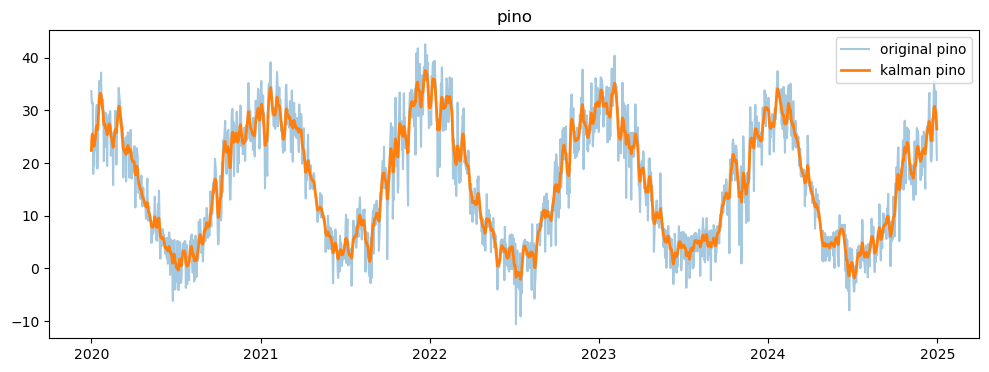

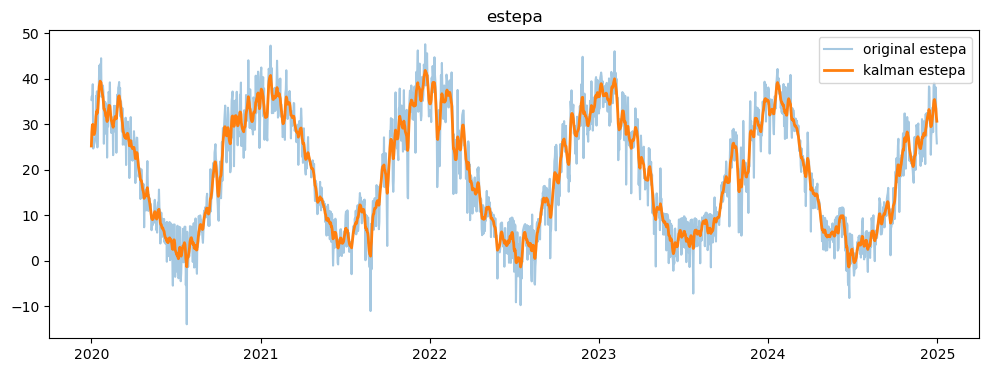

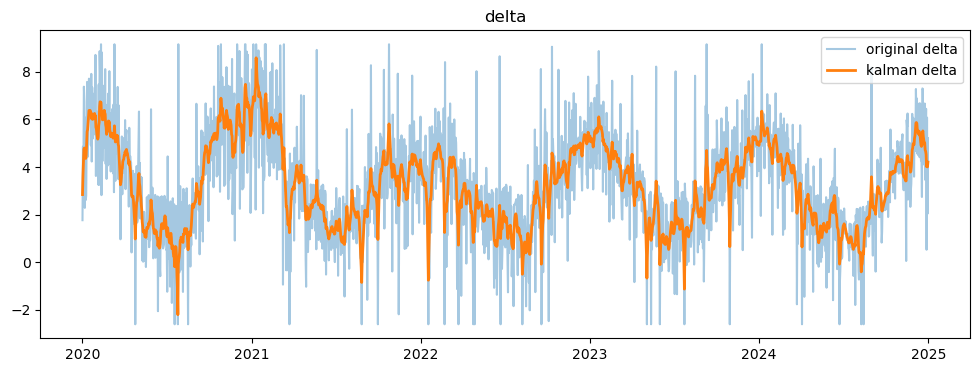

In [110]:
# Cómo dio este filtro? Exploración visual
for col in ['pino', 'estepa', 'delta']:
    plt.figure(figsize=(12,4))
    plt.plot(df.index, df_imputed[col], alpha=0.4, label=f'original {col}')
    plt.plot(df.index, df_imputed[f'{col}_kalman'], label=f'kalman {col}', linewidth=2)
    plt.title(col)
    plt.legend()
    plt.show()


In [116]:
# Las estadísticas confirman el resultado
df_imputed[['estepa', 'pino', 'delta', 'estepa_kalman',
       'pino_kalman', 'delta_kalman']].describe()

,estepa,pino,delta,estepa_kalman,pino_kalman,delta_kalman
count,1827.000000,1827.000000,1827.000000,1827.000000,1827.000000,1827.000000
mean,19.410603,16.178646,3.231958,19.399474,16.169012,3.230461
std,11.915719,10.473290,1.706826,11.805049,10.370575,1.649758
min,-1.338646,-2.107995,-2.199556,0.064818,-1.038925,-0.518987
25%,7.974162,5.811172,1.813475,7.877120,5.627056,1.830286
50%,19.537445,16.398073,3.215149,19.636177,16.207982,3.122806
75%,30.328639,25.620079,4.516143,30.558258,25.807847,4.484847
max,41.854429,37.598597,8.582913,40.685045,36.530895,7.663538


In [111]:
# Exporta el resultado
df_imputed['estepa'] = df_imputed['estepa_kalman']
df_imputed['pino'] = df_imputed['pino_kalman']
df_imputed['delta'] = df_imputed['delta_kalman']
salida = 'csv/ts_imputado_bilstm_k.csv'
#df_imputed[['fecha','estepa','pino','mes','delta']].to_csv(salida, index=False)